# **Geospatial Analysis Project 1**

You are given the following spatial datasets with BUTM projection for Noapara
municipality, Khulna.

 a. Primary_school_point
 b. Road
 c. Ward_boundary
 d. River

❑Find out the Noapara municipal boundary from Noapara ward boundary.

❑According to accessibility standard, if a primary school provide service within 
 500m  from its center point, calculate the area and percentage of served, 
 overserved and underserved area.

❑Show the existing practical boundary of served area. 

❑Show the served area through network analyst and compare among results.

❑Analyze the existing situation of primary school by ward and propose 3 
 probable location for new school.  

## SOLUTION

In [4]:
import fiona
import geopandas as gpd

gdb_path = "E:\\GIS_File\\Project\\Geo-project\\1st\\Primary School.gdb\\Primary School.gdb"

layers = fiona.listlayers(gdb_path)
print("Layers available:", layers)

Layers available: ['Primary_school_point', 'Road', 'Ward_boundary', 'River']


In [5]:
primary_schools = gpd.read_file(gdb_path, layer='Primary_school_point')
roads = gpd.read_file(gdb_path, layer='Road')
wards = gpd.read_file(gdb_path, layer='Ward_boundary')
rivers = gpd.read_file(gdb_path, layer='River')

In [6]:
# Dissolve all ward polygons into one municipal boundary
noapara_boundary = wards.unary_union

# Or if wards have a municipality attribute, filter first (adjust the column name accordingly)
# noapara_wards = wards[wards['municipality_name_column'] == 'Noapara']
# noapara_boundary = noapara_wards.unary_union

# Create GeoDataFrame for plotting later
municipal_boundary_gdf = gpd.GeoDataFrame(geometry=[noapara_boundary], crs=wards.crs)

C:\Users\HP\AppData\Local\Temp\ipykernel_15464\2295140387.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  noapara_boundary = wards.unary_union


In [7]:
from shapely.ops import unary_union

# Buffer around each school - 500m radius (assuming CRS in meters)
school_buffers = primary_schools.buffer(500)

# Union of all buffers = total served area
served_area = unary_union(school_buffers)
served_area_gdf = gpd.GeoDataFrame(geometry=[served_area], crs=wards.crs)


In [8]:
# Calculate total municipal area
total_area = municipal_boundary_gdf.geometry.area.iloc[0]

# Calculate served area
served_area_value = served_area.area

# Calculate overserved area (areas covered by 2+ buffers)
from shapely.geometry import Polygon

overserved_areas = []
for i, buf1 in enumerate(school_buffers):
    for j, buf2 in enumerate(school_buffers):
        if i >= j:
            continue
        inter = buf1.intersection(buf2)
        if not inter.is_empty:
            overserved_areas.append(inter)

if overserved_areas:
    overserved_union = unary_union(overserved_areas)
    overserved_area_value = overserved_union.area
else:
    overserved_area_value = 0

# Calculate underserved area (municipal boundary - served area)
underserved_area = municipal_boundary_gdf.geometry.iloc[0].difference(served_area)
underserved_area_value = underserved_area.area

# Print percentages
print(f"Total area: {total_area:.2f} sq.m")
print(f"Served area: {served_area_value:.2f} sq.m ({served_area_value/total_area*100:.2f}%)")
print(f"Overserved area: {overserved_area_value:.2f} sq.m ({overserved_area_value/total_area*100:.2f}%)")
print(f"Underserved area: {underserved_area_value:.2f} sq.m ({underserved_area_value/total_area*100:.2f}%)")


Total area: 27429149.92 sq.m
Served area: 10880887.96 sq.m (39.67%)
Overserved area: 788535.55 sq.m (2.87%)
Underserved area: 17917702.75 sq.m (65.32%)


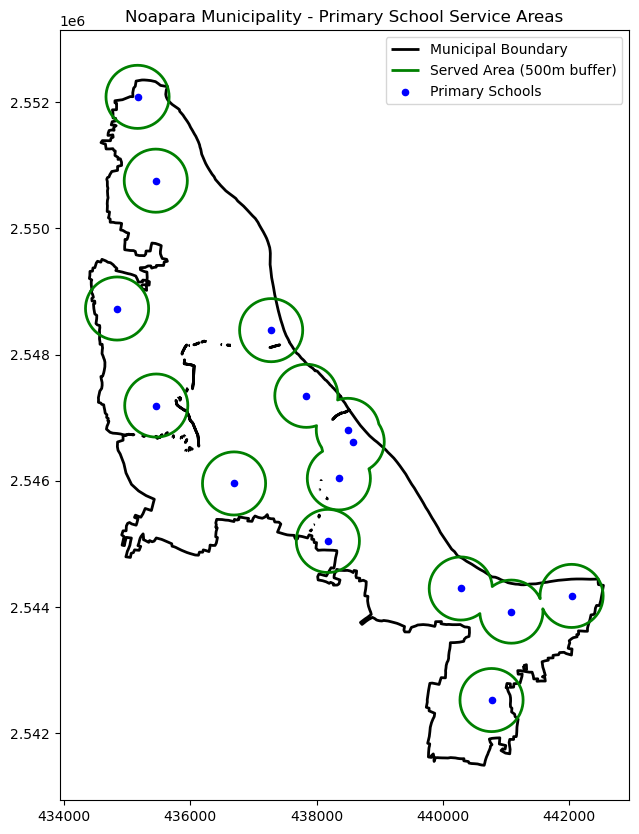

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
municipal_boundary_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='Municipal Boundary')
served_area_gdf.boundary.plot(ax=ax, color='green', linewidth=2, label='Served Area (500m buffer)')
primary_schools.plot(ax=ax, color='blue', markersize=20, label='Primary Schools')

plt.legend()
plt.title('Noapara Municipality - Primary School Service Areas')
plt.show()


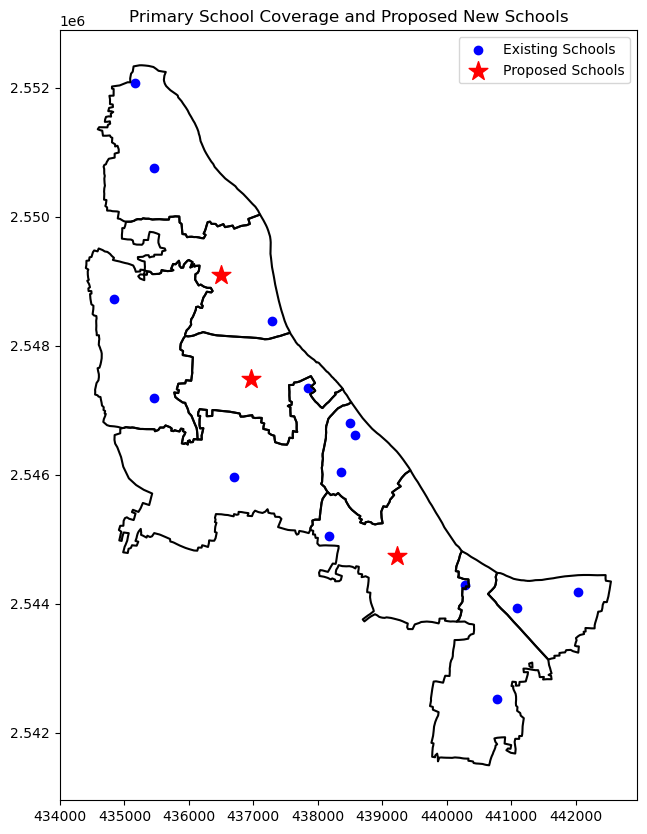

In [10]:
# Calculate served area within each ward
wards['served_area'] = wards.geometry.intersection(served_area).area
wards['served_percent'] = wards['served_area'] / wards.geometry.area * 100

# Identify underserved wards (<50% coverage)
underserved_wards = wards[wards['served_percent'] < 50]

# Propose 3 new school locations at centroids of most underserved wards
proposed_locations = underserved_wards.sort_values('served_percent').head(3).geometry.centroid

# Plot wards, existing schools, and proposed schools
fig, ax = plt.subplots(figsize=(10, 10))
wards.boundary.plot(ax=ax, color='black')
primary_schools.plot(ax=ax, color='blue', label='Existing Schools')
proposed_locations.plot(ax=ax, color='red', marker='*', markersize=200, label='Proposed Schools')

plt.legend()
plt.title('Primary School Coverage and Proposed New Schools')
plt.show()
